In [1]:
import os
import yaml
from munch import munchify

In [2]:
# define repo name and get root working directory
repo = 'process-api'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]
root_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\process-api'

In [3]:
# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
cfg_path = os.path.join( cfg_path, 'public' )
cfg_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\process-api\\cfg\\public'

In [4]:
# get pathname to configuration file
cfg_file = os.path.join( cfg_path, 'global-land-cover-lcc.yml' )

In [5]:
# print contents of configuration file
with open( cfg_file ) as f:
    print ( f.read() )

request:
    evalscript: |
                //VERSION=3
                function setup() {
                    return {
                        input: [ { bands: [ "Discrete_Classification_map" ],
                                units: [ "DN" ] 
                        }],
                        output: { bands: 1, sampleType: SampleType.UINT16  }
                    };
                }
                function evaluatePixel(sample) {
                    return [ sample.Discrete_Classification_map ]
                }  
    inputs:
        - collection: byoc-f0a97620-0e88-4c1f-a1ac-bb388fabdf2c
responses:
    default: TIFF



In [6]:
# load cfg file using yaml parser
with open( cfg_file, 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )

In [7]:
from processapi import Client

# create process api client
client = Client( config, base_url='https://creodias.sentinel-hub.com' )

In [8]:
import pandas as pd

# create asset dataframe
df = pd.DataFrame( { 'Name' : [ 'James Walker Textiles Limited' ],
                     'Latitude' : [ 53.669061 ],
                     'Longitude' : [ -1.688566 ] } )

In [9]:
import geopandas as gpd

# convert dataframe to geodataframe
gdf = gpd.GeoDataFrame( df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
gdf = gdf.set_crs( 4326 )
gdf

,Name,Latitude,Longitude,geometry
0,James Walker Textiles Limited,53.669061,-1.688566,POINT (-1.68857 53.66906)


In [10]:
gdf = gdf.to_crs( gdf.estimate_utm_crs() )
gdf.crs.to_epsg()

32630

In [11]:
gdf[ 'buffer' ] = gdf.buffer( 25000 )
gdf

,Name,Latitude,Longitude,geometry,buffer
0,James Walker Textiles Limited,53.669061,-1.688566,POINT (586642.019 5947501.126),"POLYGON ((611642.019 5947501.126, 611521.637 5..."


In [12]:
# pick a few dates
from datetime import datetime
timeframe = { 'start' : datetime( 2016, 1, 1, 0, 0, 0 ), 
                'end' : datetime( 2020, 12, 31, 23, 59, 59 ) }

In [13]:
from sentinelhub import CRS

coords = gdf.iloc[ 0 ].buffer.bounds
bbox = client.getBoundingBox( coords, src_crs=CRS( gdf.crs.to_epsg() ) )

resolution=100

In [14]:
# get aoi image dimensions
client.getBoxDimensions( bbox, resolution )

(500, 500)

In [15]:
# get S2 acquisitions between start / end dates satisfying filter conditions
timestamps = client.getDatasetTimeStamps ( config.request.inputs[ 0 ], bbox, timeframe )
timestamps

[datetime.datetime(2016, 1, 1, 0, 0, tzinfo=tzutc()),
 datetime.datetime(2017, 1, 1, 0, 0, tzinfo=tzutc()),
 datetime.datetime(2018, 1, 1, 0, 0, tzinfo=tzutc()),
 datetime.datetime(2019, 1, 1, 0, 0, tzinfo=tzutc())]

In [16]:
# get time series
response = client.getTimeSeries ( bbox, timeframe, resolution=resolution )
response._df

,default,time
0,"[[30, 30, 30, 30, 30, 126, 40, 30, 30, 30, 30,...",2016-01-01 00:00:00+00:00
1,"[[30, 30, 30, 30, 30, 126, 40, 30, 30, 30, 30,...",2017-01-01 00:00:00+00:00
2,"[[30, 30, 30, 30, 30, 126, 40, 30, 30, 30, 30,...",2018-01-01 00:00:00+00:00
3,"[[30, 30, 30, 30, 30, 126, 40, 30, 30, 30, 30,...",2019-01-01 00:00:00+00:00


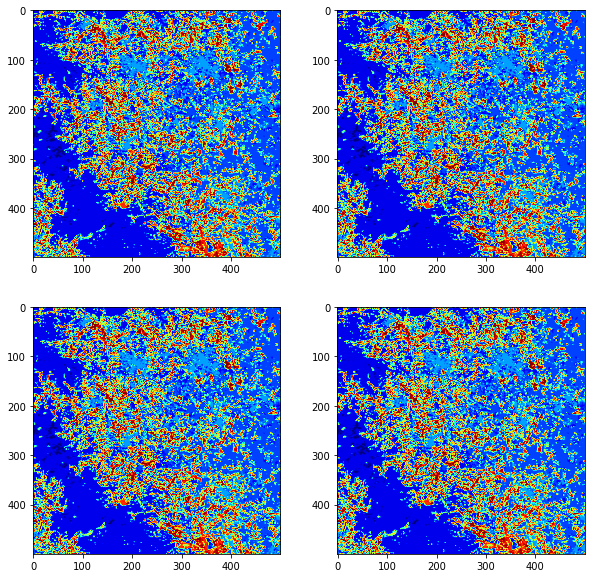

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots( figsize=( 10,10 ), nrows=2, ncols=2 )

axes[0][0].imshow( response._df.iloc[ 0 ][ 'default' ], cmap='jet' )
axes[0][1].imshow( response._df.iloc[ 1 ][ 'default' ], cmap='jet' )
axes[1][0].imshow( response._df.iloc[ 2 ][ 'default' ], cmap='jet' )
axes[1][1].imshow( response._df.iloc[ 3 ][ 'default' ], cmap='jet' )

In [18]:
lcc = response._df.iloc[ 0 ][ 'default' ]
type( lcc )

numpy.ndarray

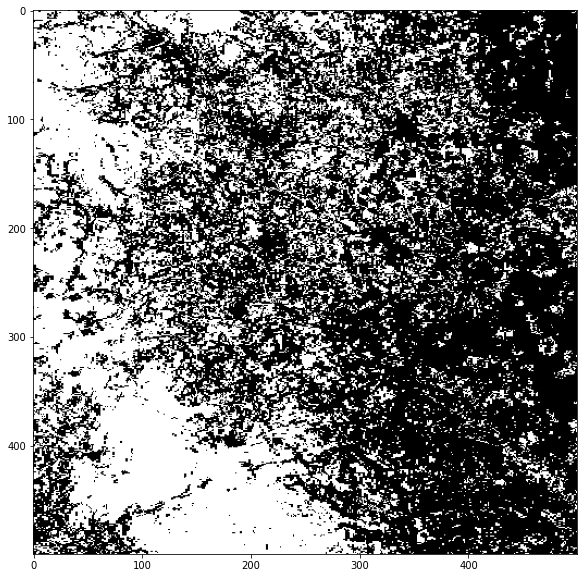

In [40]:
import numpy as np 

mask = np.uint8( ( lcc == 30 ) )
_, ax = plt.subplots( figsize=(10,10) )
ax.imshow( mask, cmap='gray' )

In [20]:
import affine
transform = affine.Affine.from_gdal( *response._transform )
transform

Affine(100.0, 0.0, 561642.0187056297,
       0.0, -100.0, 5972501.125816977)

In [21]:
import rasterio.features
from shapely.geometry import shape

shapes = rasterio.features.shapes(mask, mask=mask, transform=transform)

values = []; geometry = []
for feature, value in shapes:
    values.append(value)
    geometry.append(shape(feature))

# build the gdf object over the two lists
aois = gpd.GeoDataFrame(
    {'value': value, 'geometry': geometry }, crs="EPSG:{}".format( gdf.crs.to_epsg() )
)
aois[ 'area' ] = aois[ 'geometry' ].area
aois[ 'perimeter' ] = aois[ 'geometry' ].length
aois = aois.sort_values( 'area', ascending=False )
aois

,value,geometry,area,perimeter
5014,1.0,"POLYGON ((564242.019 5954801.126, 564342.019 5...",420390000.0,1295000.0
2125,1.0,"POLYGON ((561642.019 5972501.126, 562142.019 5...",159460000.0,626200.0
382,1.0,"POLYGON ((571542.019 5972501.126, 572742.019 5...",29260000.0,147400.0
281,1.0,"POLYGON ((584542.019 5972501.126, 584642.019 5...",13950000.0,99200.0
868,1.0,"POLYGON ((583442.019 5967201.126, 583642.019 5...",10330000.0,97400.0
...,...,...,...,...
3949,1.0,"POLYGON ((582242.019 5935601.126, 582242.019 5...",10000.0,400.0
1614,1.0,"POLYGON ((606142.019 5955801.126, 606142.019 5...",10000.0,400.0
778,1.0,"POLYGON ((599742.019 5963601.126, 599742.019 5...",10000.0,400.0
3944,1.0,"POLYGON ((599942.019 5935701.126, 599942.019 5...",10000.0,400.0


In [22]:
subset = aois[ : 10 ]
subset

,value,geometry,area,perimeter
5014,1.0,"POLYGON ((564242.019 5954801.126, 564342.019 5...",420390000.0,1295000.0
2125,1.0,"POLYGON ((561642.019 5972501.126, 562142.019 5...",159460000.0,626200.0
382,1.0,"POLYGON ((571542.019 5972501.126, 572742.019 5...",29260000.0,147400.0
281,1.0,"POLYGON ((584542.019 5972501.126, 584642.019 5...",13950000.0,99200.0
868,1.0,"POLYGON ((583442.019 5967201.126, 583642.019 5...",10330000.0,97400.0
1409,1.0,"POLYGON ((585942.019 5960301.126, 586242.019 5...",8030000.0,68600.0
570,1.0,"POLYGON ((570342.019 5968901.126, 570742.019 5...",6860000.0,56600.0
3419,1.0,"POLYGON ((577342.019 5944301.126, 577442.019 5...",5540000.0,48400.0
2676,1.0,"POLYGON ((571942.019 5950701.126, 572342.019 5...",4900000.0,41000.0
3562,1.0,"POLYGON ((587942.019 5942601.126, 588142.019 5...",4550000.0,35400.0


<AxesSubplot:>

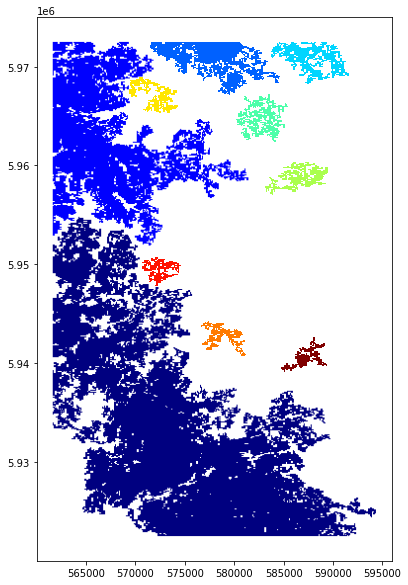

In [23]:
_,ax = plt.subplots( figsize=(10,10))
subset.plot( ax=ax, cmap='jet' )

In [24]:
cx = gdf.to_crs( 4326 ).iloc[ 0 ].geometry.centroid.x
cy = gdf.to_crs( 4326 ).iloc[ 0 ].geometry.centroid.y
cx, cy

(-1.688566, 53.669061000000006)

In [25]:
subset = subset.to_crs( 4326 )
subset

,value,geometry,area,perimeter
5014,1.0,"POLYGON ((-2.02604 53.73790, -2.02452 53.73789...",420390000.0,1295000.0
2125,1.0,"POLYGON ((-2.06191 53.89728, -2.05430 53.89722...",159460000.0,626200.0
382,1.0,"POLYGON ((-1.91127 53.89601, -1.89301 53.89584...",29260000.0,147400.0
281,1.0,"POLYGON ((-1.71349 53.89405, -1.71197 53.89404...",13950000.0,99200.0
868,1.0,"POLYGON ((-1.73167 53.84661, -1.72863 53.84658...",10330000.0,97400.0
1409,1.0,"POLYGON ((-1.69560 53.78420, -1.69105 53.78415...",8030000.0,68600.0
570,1.0,"POLYGON ((-1.93036 53.86382, -1.92428 53.86377...",6860000.0,56600.0
3419,1.0,"POLYGON ((-1.83010 53.64176, -1.82858 53.64175...",5540000.0,48400.0
2676,1.0,"POLYGON ((-1.91028 53.70005, -1.90422 53.69999...",4900000.0,41000.0
3562,1.0,"POLYGON ((-1.67028 53.62481, -1.66726 53.62478...",4550000.0,35400.0


In [26]:
import folium
m = folium.Map(location=[ cy, cx ], zoom_start=10, tiles='CartoDB positron')

for _, r in subset.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)
m

In [27]:
# define repo name and get root working directory
repo = 'sentinelhub'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]
root_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub'

In [28]:
# get path to configuration files
cfg_path = os.path.join( root_path, 'statistical-api/cfg' )
cfg_path = os.path.join( cfg_path, 'sentinel-2' )
cfg_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\statistical-api/cfg\\sentinel-2'

In [29]:
# get pathname to configuration file
cfg_file = os.path.join( cfg_path, 's2-ndvi-maximum.yml' )

# print contents of configuration file
with open( cfg_file ) as f:
    print ( f.read() )

request:
    evalscript: |       
                //VERSION=3
                function setup() {
                    return {
                        input: [ {
                            bands: [
                                "B04",
                                "B08",
                                "SCL",
                                "dataMask"
                            ]
                        } ],
                        mosaicking: "ORBIT",
                        output: [
                            {
                                id: "data",
                                bands: ["monthly_max_ndvi"]
                            },
                            {
                                id: "dataMask",
                                bands: 1
                            } ]
                    }
                }
                function evaluatePixel(samples) {
                    var max = 0;
                    var hasData = 0;
                    for (var

In [30]:
# load cfg file using yaml parser
with open( cfg_file, 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )

In [31]:
from statisticalapi import Client
obj = Client( config )

In [32]:
# define aggregation timeframe
from datetime import datetime
timeframe = { 'start' : datetime.strptime('2020-01-01', '%Y-%m-%d'), 
              'end' : datetime.strptime('2020-12-31', '%Y-%m-%d') }

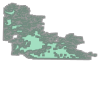

In [33]:
subset.geometry.values[ 0 ]

In [34]:
subset = subset.to_crs( "EPSG:{}".format( gdf.crs.to_epsg() ) )

from shapely.geometry import MultiPolygon
aoi = gpd.GeoDataFrame( geometry=gpd.GeoSeries( MultiPolygon( subset.geometry.values ) ) )
aoi = aoi.set_crs( subset.crs )
aoi

,geometry
0,"MULTIPOLYGON (((564242.019 5954801.126, 564342..."


In [35]:
response = obj.getStatistics( [ timeframe ], resolution=100, polygons=aoi, interval='P30D' ) 

In [36]:
response._dfs[ 0 ]

,interval_from,interval_to,data_monthly_max_ndvi_min,data_monthly_max_ndvi_max,data_monthly_max_ndvi_mean,data_monthly_max_ndvi_stDev,data_monthly_max_ndvi_sampleCount,data_monthly_max_ndvi_noDataCount
0,2020-01-01,2020-01-31,0.004586,1.000000,0.526219,0.195774,163500,97173
1,2020-01-31,2020-03-01,0.015403,0.998668,0.586540,0.176156,163500,97173
2,2020-03-01,2020-03-31,0.011298,0.943590,0.578292,0.149424,163500,97173
3,2020-03-31,2020-04-30,0.066202,0.962380,0.601704,0.174712,163500,97173
4,2020-04-30,2020-05-30,0.000000,0.957351,0.648914,0.155088,163500,97173
5,2020-05-30,2020-06-29,0.027091,1.000000,0.712085,0.144836,163500,97173
6,2020-06-29,2020-07-29,0.014226,0.940613,0.498157,0.287531,163500,97173
7,2020-07-29,2020-08-28,0.046794,1.000000,0.735340,0.113275,163500,97173
8,2020-08-28,2020-09-27,0.039864,0.993450,0.750057,0.101567,163500,97173
9,2020-09-27,2020-10-27,0.031508,1.000000,0.539529,0.221939,163500,97173


In [38]:
response._dfs[ 0 ]

,interval_from,interval_to,data_monthly_max_ndvi_min,data_monthly_max_ndvi_max,data_monthly_max_ndvi_mean,data_monthly_max_ndvi_stDev,data_monthly_max_ndvi_sampleCount,data_monthly_max_ndvi_noDataCount
0,2020-01-01,2020-01-31,0.004586,1.000000,0.526219,0.195774,163500,97173
1,2020-01-31,2020-03-01,0.015403,0.998668,0.586540,0.176156,163500,97173
2,2020-03-01,2020-03-31,0.011298,0.943590,0.578292,0.149424,163500,97173
3,2020-03-31,2020-04-30,0.066202,0.962380,0.601704,0.174712,163500,97173
4,2020-04-30,2020-05-30,0.000000,0.957351,0.648914,0.155088,163500,97173
5,2020-05-30,2020-06-29,0.027091,1.000000,0.712085,0.144836,163500,97173
6,2020-06-29,2020-07-29,0.014226,0.940613,0.498157,0.287531,163500,97173
7,2020-07-29,2020-08-28,0.046794,1.000000,0.735340,0.113275,163500,97173
8,2020-08-28,2020-09-27,0.039864,0.993450,0.750057,0.101567,163500,97173
9,2020-09-27,2020-10-27,0.031508,1.000000,0.539529,0.221939,163500,97173
